<a href="https://colab.research.google.com/github/fridapolanco/AI_Iowa_Retail_2024_Analysis/blob/main/4_IOWA_USA_VODKA_FORECAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IOWA RETAIL ANALYSIS**: 🍺 Retail in AI
#FORECASTING **AMERICAN VODKAS**

**TEAM:**

Frida Nicole Polanco Domínguez,

Nicole Herrera,

Alina Edigareva

[Inspo](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet)

##**SETTING UP NOTEBOOK**

In [ ]:
!pip install prophet

import prophet

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
plt.style.use('fivethirtyeight') # For plots

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_2021 = pd.read_csv("/content/drive/MyDrive/IOWA/2021_onwards_clean.csv") #Reading from clean CSV to avoid having to run all cleaning cells.

In [ ]:
df_2021['Date'] = pd.to_datetime(df_2021['Date'])
df_2021 = df_2021.set_index('Date')
df_2021.sort_index(inplace=True)

In [ ]:
df_2021.rename(columns={"Store Name": "store_name",
                        "Store Number": "store_number",
                        "Address": "address",
                        "City":"city",
                        "Zip Code":"zip",
                        "County":"county",
                        "Category Name":"category",
                        "Vendor Name":"vendor_name",
                        "Item Description":"item",
                        "Pack":"pack",
                        "Bottle Volume (ml)":"bottle_ml",
                        "State Bottle Cost":"cost",
                        "State Bottle Retail":"retail",
                        "Bottles Sold": "bottles_sold",
                        "Sale (Dollars)": "sale_usd",
                        "Volume Sold (Liters)": "sale_liters",
                        "Store Status": "store_status",
                        },
               inplace=True)

In [ ]:
#Filtering gor 100% Agave Tequila
vodka_df = df_2021[df_2021.category == "AMERICAN VODKAS"]

##**FORECAST**

In [ ]:
#Resampling to weekly granularity
datos = vodka_df["sale_usd"].resample("W").sum()

In [ ]:
datos.describe()

,sale_usd
count,2.090000e+02
mean,1.236544e+06
std,2.487223e+05
min,4.007486e+05
25%,1.076329e+06
50%,1.207275e+06
75%,1.374202e+06
max,2.036428e+06


In [ ]:
#Splitting around 30% of the data to test
split_date = '01-Oct-2023'
train = datos.loc[datos.index <= split_date].copy()
test = datos.loc[datos.index > split_date].copy()

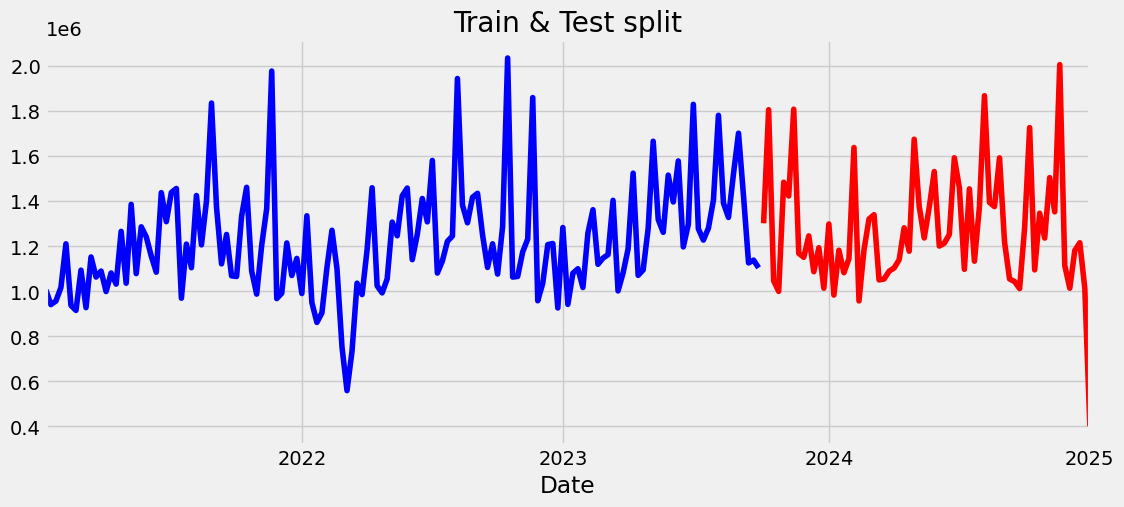

In [ ]:
train.plot(figsize=(12, 5), title="Train set", color="blue");
test.plot(figsize=(12, 5), title="Test set", color="red");
plt.title("Train & Test split")
plt.show()

In [ ]:
train.head()

,sale_usd
Date,
2021-01-10,1006574.46
2021-01-17,940849.86
2021-01-24,956652.09
2021-01-31,1016791.20
2021-02-07,1210906.10


In [ ]:
#Format data to be as prophet needs it
train_prophet = train.reset_index().rename(columns={"Date":"ds","sale_usd":"y"})
test_prophet = test.reset_index().rename(columns={"Date":"ds","sale_usd":"y"})

In [ ]:
#Instantiate the model

from prophet import Prophet

model = Prophet(weekly_seasonality=True)
model.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9l8i4izq/niv5v4k4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9l8i4izq/xy4c_yt7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43552', 'data', 'file=/tmp/tmp9l8i4izq/niv5v4k4.json', 'init=/tmp/tmp9l8i4izq/xy4c_yt7.json', 'output', 'file=/tmp/tmp9l8i4izq/prophet_modelpmd8yht9/prophet_model-20250306134718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:47:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:47:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Testing
test_forecast = model.predict(test_prophet)

In [ ]:
#The results show all the components of the prediction. yhat, the last column, is the predicted one
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-10-08,1.200362e+06,1.217097e+06,1.646359e+06,1.200362e+06,1.200362e+06,231603.510544,231603.510544,231603.510544,103129.824167,103129.824167,103129.824167,128473.686377,128473.686377,128473.686377,0.0,0.0,0.0,1.431966e+06
1,2023-10-15,1.201483e+06,1.289274e+06,1.737268e+06,1.201483e+06,1.201483e+06,310299.329689,310299.329689,310299.329689,103129.824167,103129.824167,103129.824167,207169.505522,207169.505522,207169.505522,0.0,0.0,0.0,1.511782e+06
2,2023-10-22,1.202603e+06,1.157308e+06,1.607158e+06,1.202603e+06,1.202603e+06,186541.414877,186541.414877,186541.414877,103129.824167,103129.824167,103129.824167,83411.590710,83411.590710,83411.590710,0.0,0.0,0.0,1.389145e+06
3,2023-10-29,1.203724e+06,9.790194e+05,1.434261e+06,1.203724e+06,1.203724e+06,14678.360340,14678.360340,14678.360340,103129.824167,103129.824167,103129.824167,-88451.463827,-88451.463827,-88451.463827,0.0,0.0,0.0,1.218402e+06
4,2023-11-05,1.204844e+06,9.757445e+05,1.445980e+06,1.204844e+06,1.204844e+06,9173.056712,9173.056712,9173.056712,103129.824167,103129.824167,103129.824167,-93956.767455,-93956.767455,-93956.767455,0.0,0.0,0.0,1.214017e+06


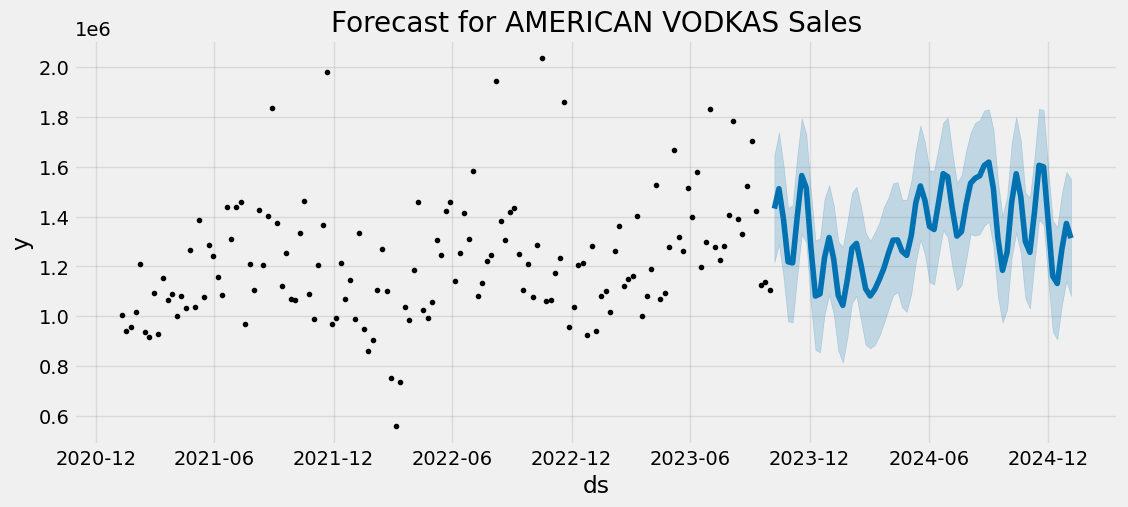

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
fig = model.plot(test_forecast, ax=ax)
ax.set_title("Forecast for AMERICAN VODKAS Sales")
plt.show()

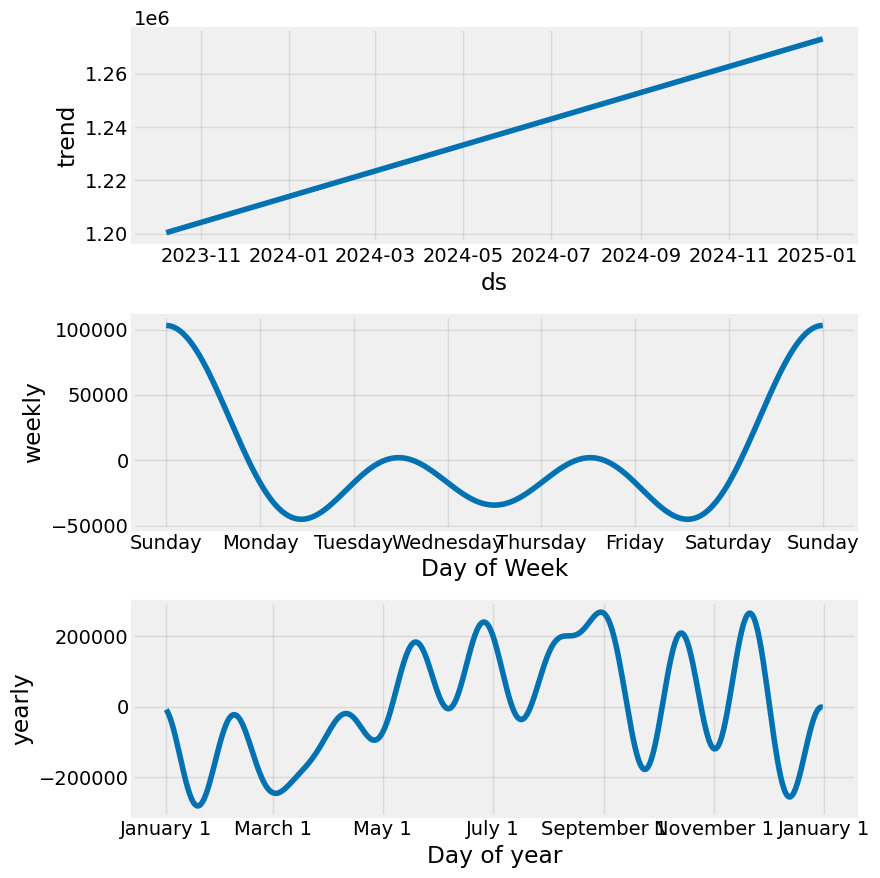

In [ ]:
#Checking seasonality trends
model.plot_components(test_forecast)
plt.show()

In [ ]:
test

,sale_usd
Date,
2023-10-08,1301962.06
2023-10-15,1806582.47
2023-10-22,1046577.60
2023-10-29,999579.45
2023-11-05,1484560.30
...,...
2024-12-08,1013602.40
2024-12-15,1181391.20
2024-12-22,1215702.85


Text(0.5, 1.0, 'Forecast vs Actuals')

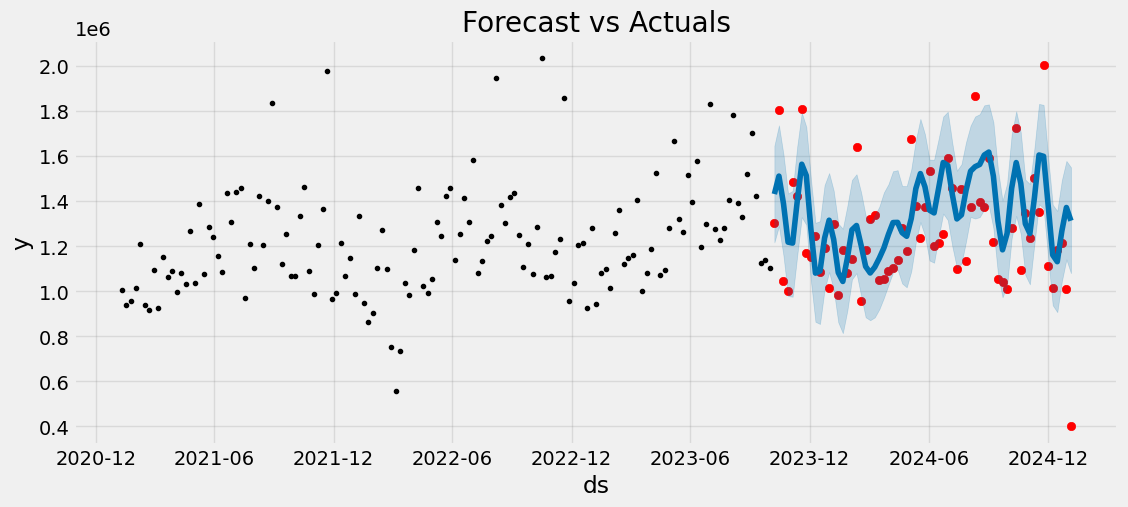

In [ ]:
#COMPARE FORECAST TO ACTUALS

f, ax = plt.subplots(figsize=(12, 5))
# Use test["sale_usd"] to get the actual sales data for the y-axis
ax.scatter(test.index, test_prophet["y"], color ="r")
fig = model.plot(test_forecast, ax=ax)
ax.set_title("Forecast vs Actuals")

#red = true, blue = forecast

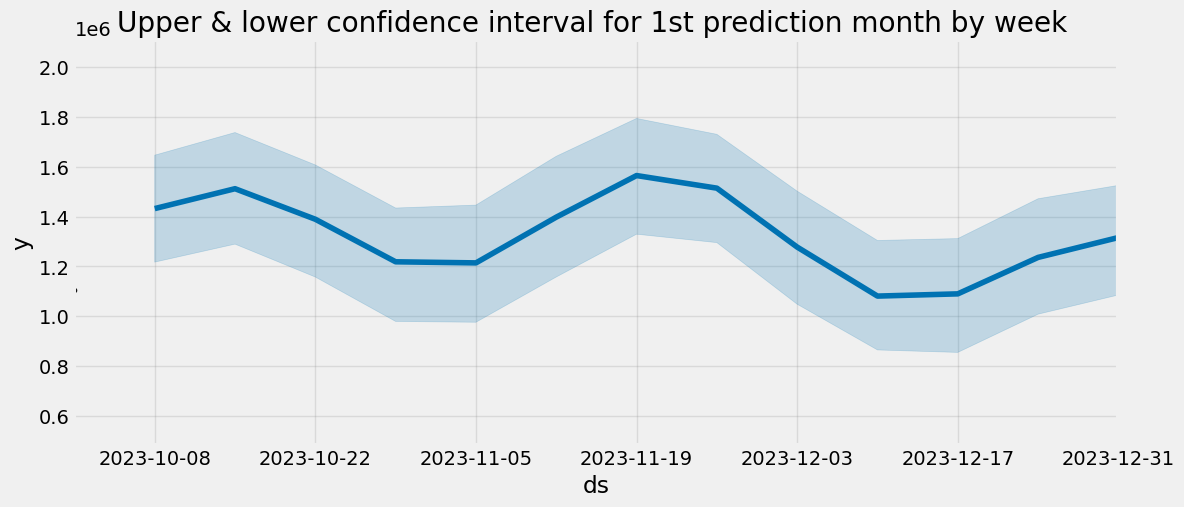

In [ ]:
#Comparing first 3 month of predictions

# Create a new figure and axes for this plot
fig, ax = plt.subplots(figsize=(12, 5))

fid = model.plot(test_forecast, ax=ax)
# Convert the date strings to pandas Timestamp objects
ax.set_xbound(lower=pd.Timestamp('2023-10-01'), upper=pd.Timestamp('2023-12-31'))
ax.set_title("Upper & lower confidence interval for 1st prediction month by week ")
plt.show()

In [ ]:
#Evaluating error metrics

np.sqrt(mean_squared_error(y_true=test_prophet["y"], y_pred=test_forecast["yhat"]))

236136.10299862354

In [ ]:
mean_absolute_error(y_true=test_prophet["y"], y_pred=test_forecast["yhat"])

190463.79324515592

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_true=test_prophet["y"], y_pred=test_forecast["yhat"])

0.17599728413547241

##**PREDICTIONS**

In [ ]:
#Predicting in the future

future = model.make_future_dataframe(periods=4*52, freq="W", include_history=False)
forecasted_sales = model.predict(future)

In [ ]:
forecasted_sales.ds.describe()

,ds
count,208
mean,2025-10-01 12:00:00
min,2023-10-08 00:00:00
25%,2024-10-04 06:00:00
50%,2025-10-01 12:00:00
75%,2026-09-28 18:00:00
max,2027-09-26 00:00:00


In [ ]:
forecasted_sales[["ds","yhat"]]

,ds,yhat
0,2023-10-08,1.431966e+06
1,2023-10-15,1.511782e+06
2,2023-10-22,1.389145e+06
3,2023-10-29,1.218402e+06
4,2023-11-05,1.214017e+06
...,...,...
203,2027-08-29,1.797129e+06
204,2027-09-05,1.761482e+06
205,2027-09-12,1.597546e+06
206,2027-09-19,1.407809e+06


In [ ]:
print(f"Total predicted sales for 2025 is {forecasted_sales[(forecasted_sales.ds > '2025-01-01') & (forecasted_sales.ds <= '2025-12-31')].yhat.sum()}")

Total predicted sales for 2025 is 73054544.3209251


In [ ]:
print(f"Total predicted sales for 2026 is {forecasted_sales[(forecasted_sales.ds > '2026-01-01') & (forecasted_sales.ds <= '2026-12-31')].yhat.sum()}")

Total predicted sales for 2026 is 76083221.87443732


**GRAPHING REAL & PREDICTED TOGETHER**

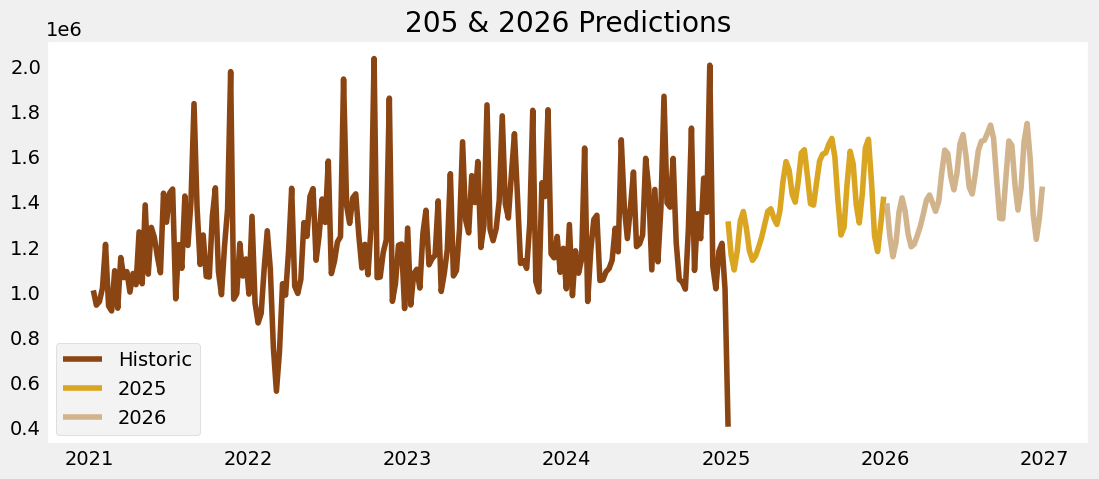

In [ ]:
real = datos.copy()
forecast_2025 = forecasted_sales[(forecasted_sales.ds > '2025-01-01') & (forecasted_sales.ds <= '2025-12-31')].set_index('ds')
forecast_2026 = forecasted_sales[(forecasted_sales.ds > '2026-01-01') & (forecasted_sales.ds <= '2026-12-31')].set_index('ds')

fig, ax = plt.subplots(figsize=(12, 5))
# Convert real.index to datetime objects if they are not already
real_index = pd.to_datetime(real.index, errors='coerce')

# Filter out any NaT (Not a Time) values that might have resulted from conversion errors
real_index = real_index[pd.notnull(real_index)]
real = real[real_index]

ax.plot(real_index, real, label='Historic', color='saddlebrown')
# Access the index and 'yhat' column using indexing
ax.plot(forecast_2025.index, forecast_2025['yhat'], label='2025', color='goldenrod')
ax.plot(forecast_2026.index, forecast_2026['yhat'], label='2026', color='tan')
plt.gca().set_facecolor("white")
ax.set_title("205 & 2026 Predictions")
ax.legend()
ax.grid(False)
plt.show() # Show the plot explicitly

In [ ]:
real

,sale_usd
Date,
2021-01-10,1006574.46
2021-01-17,940849.86
2021-01-24,956652.09
2021-01-31,1016791.20
2021-02-07,1210906.10
...,...
2024-12-08,1013602.40
2024-12-15,1181391.20
2024-12-22,1215702.85


In [ ]:
forecast_2025.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2025-01-05,1.273193e+06,1.098040e+06,1.540044e+06,1.273191e+06,1.273195e+06,40179.155485,40179.155485,40179.155485,103129.824167,103129.824167,103129.824167,-62950.668682,-62950.668682,-62950.668682,0.0,0.0,0.0,1.313372e+06
2025-01-12,1.274314e+06,9.485870e+05,1.404713e+06,1.274312e+06,1.274315e+06,-110459.030720,-110459.030720,-110459.030720,103129.824167,103129.824167,103129.824167,-213588.854887,-213588.854887,-213588.854887,0.0,0.0,0.0,1.163855e+06
2025-01-19,1.275434e+06,8.658224e+05,1.342734e+06,1.275432e+06,1.275436e+06,-178285.779954,-178285.779954,-178285.779954,103129.824167,103129.824167,103129.824167,-281415.604121,-281415.604121,-281415.604121,0.0,0.0,0.0,1.097148e+06
2025-01-26,1.276555e+06,9.447809e+05,1.412789e+06,1.276553e+06,1.276556e+06,-95308.293337,-95308.293337,-95308.293337,103129.824167,103129.824167,103129.824167,-198438.117504,-198438.117504,-198438.117504,0.0,0.0,0.0,1.181246e+06
2025-02-02,1.277675e+06,1.088459e+06,1.529908e+06,1.277673e+06,1.277677e+06,36810.216084,36810.216084,36810.216084,103129.824167,103129.824167,103129.824167,-66319.608084,-66319.608084,-66319.608084,0.0,0.0,0.0,1.314485e+06


In [ ]:
forecast_2025 = forecast_2025.yhat

In [ ]:
forecast_2026 = forecast_2026.yhat
forecast_2026.head()

,yhat
ds,
2026-01-04,1.393607e+06
2026-01-11,1.247606e+06
2026-01-18,1.155933e+06
2026-01-25,1.216559e+06
2026-02-01,1.352695e+06


In [ ]:
forecast_2025 = forecast_2025.rename('sale_usd')  # Rename the series to 'sale_usd'
forecast_2026 = forecast_2026.rename('sale_usd')  # Rename the Series to 'sale_usd'

In [ ]:
forecast_2025.head()

,sale_usd
ds,
2025-01-05,1.313372e+06
2025-01-12,1.163855e+06
2025-01-19,1.097148e+06
2025-01-26,1.181246e+06
2025-02-02,1.314485e+06


In [ ]:
all = pd.concat([real, forecast_2025, forecast_2026], axis=0) # Changed pd.union to pd.concat and specified axis=0 to concatenate rows

In [ ]:
all.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 313 entries, 2021-01-10 to 2026-12-27
Series name: sale_usd
Non-Null Count  Dtype  
--------------  -----  
313 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB


In [ ]:
all

,sale_usd
2021-01-10,1.006574e+06
2021-01-17,9.408499e+05
2021-01-24,9.566521e+05
2021-01-31,1.016791e+06
2021-02-07,1.210906e+06
...,...
2026-11-29,1.591032e+06
2026-12-06,1.341929e+06
2026-12-13,1.233206e+06
2026-12-20,1.327969e+06


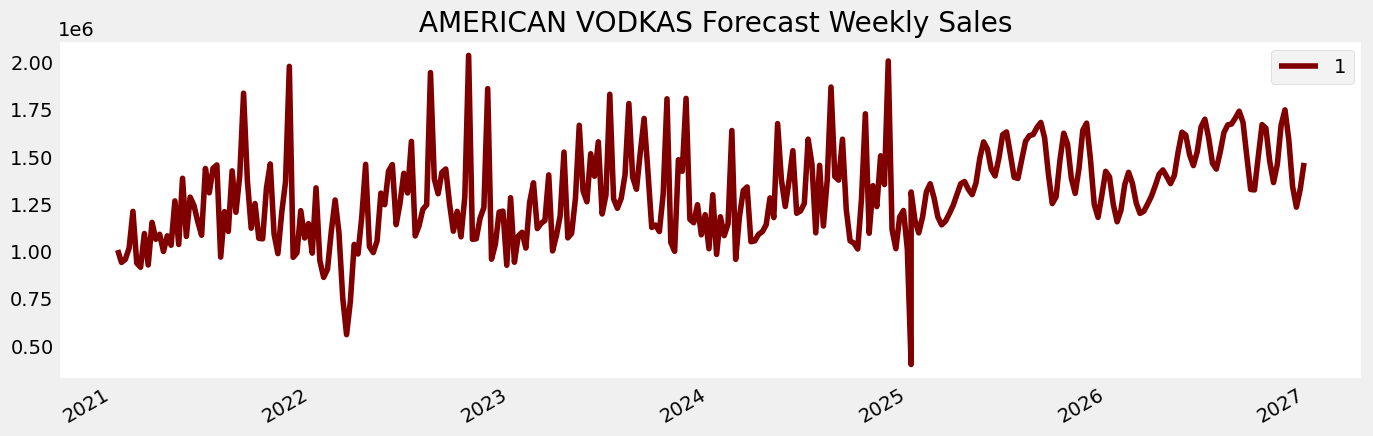

In [ ]:
all.plot(figsize=(15, 5), color="maroon")
plt.grid(False)
plt.gca().set_facecolor("white")
plt.title(" AMERICAN VODKAS Forecast Weekly Sales")
plt.style.use('fivethirtyeight')
plt.legend("100% Agave")

plt.show()

##**METRICS ANALYSIS**

Your model's performance can be evaluated based on the following metrics:

* Mean Squared Error (MSE) = 118,893.55

This value represents the average squared difference between predicted and actual values. Since MSE is in squared units of the target variable, its magnitude is harder to interpret directly, but smaller values indicate better performance.

* Mean Absolute Error (MAE) = 95,397.72

This is the average absolute difference between predicted and actual values, meaning your model's predictions are, on average, about 95,398 off from the true values. Given that the mean sale value is $566,037, this suggests a moderate error.

* Mean Absolute Percentage Error (MAPE) = 0.1658 (~16.58%)

This means your model's predictions, on average, deviate by about 16.58% from the actual values. Generally, a MAPE below 10% is considered very good, 10-20% is acceptable depending on the industry, and above 20% is often considered poor.


----

Relative to the mean sale value (566,037), an MAE of $95,398 suggests that your model is making predictions with a reasonable but non-negligible margin of error.

A MAPE of 16.58% suggests that your model is moderately accurate. It may be acceptable depending on the industry standard, but there is room for improvement.

If prediction errors significantly impact decisions (e.g., financial forecasting), then a lower MAE and MAPE would be preferable.